<a href="https://colab.research.google.com/github/QuickLearner171998/Basic-Covid-19-Classifier/blob/master/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import os
import cv2
import glob
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, inception_resnet_v2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [0]:
# helper funcs

def get_epoch_frm_model_file(save_path):
  return int(save_path[:save_path.index('_')])

def return_last_saved_model(paths):
  last_epoch_prev = -1
  ret_path = ""
  for path in paths:
    last_epoch = get_epoch_frm_model_file(path)
    if(last_epoch >= last_epoch_prev):
      last_epoch_prev = last_epoch
      ret_path = path
  return ret_path

import cv2
import numpy as np


def add_title(img,title):
  height, width, ch = img.shape
  img1 = cv2.putText(img, title, (int(0.25*width), 30), cv2.FONT_HERSHEY_COMPLEX, 1,(255, 128, 0))
  return img1

In [0]:
# config 

INIT_LR = 1e-3
EPOCHS = 25
BS = 8
# change this path
dataset_path = "Path/to/Dataset"
init_epoch = 0

In [4]:
print(" Loading Images")
# create list of Images

image_paths = [os.path.join(path,name ) for path, subdir, files in os.walk(dataset_path) for name in files ]
images = []
labels= []
for img_path in image_paths:
  labels.append(os.path.basename(os.path.dirname(img_path)))
  image = cv2.imread(img_path)
  image  = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224,224))
  images.append(image)

images = np.array(images)/255.0
labels = np.array(labels)
# One hot
l = LabelBinarizer()
labels = to_categorical(l.fit_transform(labels))

(trainX, testX, trainY, testY) = train_test_split(images, labels,
	test_size=0.20, stratify=labels, random_state=42)

#dataAug

trainAug = ImageDataGenerator(rotation_range=15,
                              fill_mode='nearest')


 Loading Images


In [5]:
# if model exists
if(glob.glob('*.h5')):
  print("loading model")
  load_path = return_last_saved_model(glob.glob('*.h5'))
  model=load_model(load_path)
  init_epoch = get_epoch_frm_model_file(load_path)

else:

  baseModel = VGG16(weights = "imagenet", include_top = False,
                    input_tensor = Input(shape=(224,224,3)))
  model = baseModel.output
  model = AveragePooling2D(pool_size=(4,4))(model)
  model = Flatten(name = 'flatten')(model)
  model = Dense(64, activation='relu')(model)
  model = Dropout(0.5)(model)
  model = Dense(2,activation='sigmoid')(model)

  model = Model(inputs = baseModel.input, outputs = model)
  for layer in baseModel.layers:
    layer.trainable = False

  print("compiling model")

  opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

  model.compile(loss = "binary_crossentropy", optimizer = opt, metrics =["accuracy"])

chk_pth = "{epoch:02d}_{val_acc: .2f}.h5"
checkpoint = ModelCheckpoint(chk_pth,monitor='val_loss', verbose=1, save_best_only='False',mode = 'auto', period=2)





Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
compiling model
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
print("START TRAINING")


history = model.fit_generator(trainAug.flow(trainX,trainY,batch_size=BS),
                              steps_per_epoch = len(trainX)//BS,
                              epochs = init_epoch+EPOCHS,
                              validation_data = (testX,testY),
                              validation_steps = len(testX)//BS,
                              callbacks =[checkpoint],
                              initial_epoch = init_epoch)

print("Training fininshed....Saving Model")
save_path = "{}_epochs-model.h5".format(init_epoch+EPOCHS)
model.save(save_path)

START TRAINING
Epoch 1/25
5/5 [==============================] - 8s 2s/step - loss: 0.8600 - acc: 0.5000 - val_loss: 0.6901 - val_acc: 0.6000
Epoch 2/25
10/5 [============================================================] - 0s 6ms/sample - loss: 0.6839 - acc: 0.5000

Epoch 00002: val_loss improved from inf to 0.68273, saving model to 02_ 0.50.h5
5/5 [==============================] - 1s 151ms/step - loss: 0.7566 - acc: 0.5000 - val_loss: 0.6827 - val_acc: 0.5000
Epoch 3/25
5/5 [==============================] - 0s 60ms/step - loss: 0.6836 - acc: 0.6000 - val_loss: 0.6726 - val_acc: 0.7000
Epoch 4/25
10/5 [============================================================] - 0s 5ms/sample - loss: 0.6624 - acc: 0.7000

Epoch 00004: val_loss improved from 0.68273 to 0.66419, saving model to 04_ 0.70.h5
5/5 [==============================] - 1s 171ms/step - loss: 0.6391 - acc: 0.6125 - val_loss: 0.6642 - val_acc: 0.7000
Epoch 5/25
5/5 [==============================] - 0s 93ms/step - loss: 0.6192

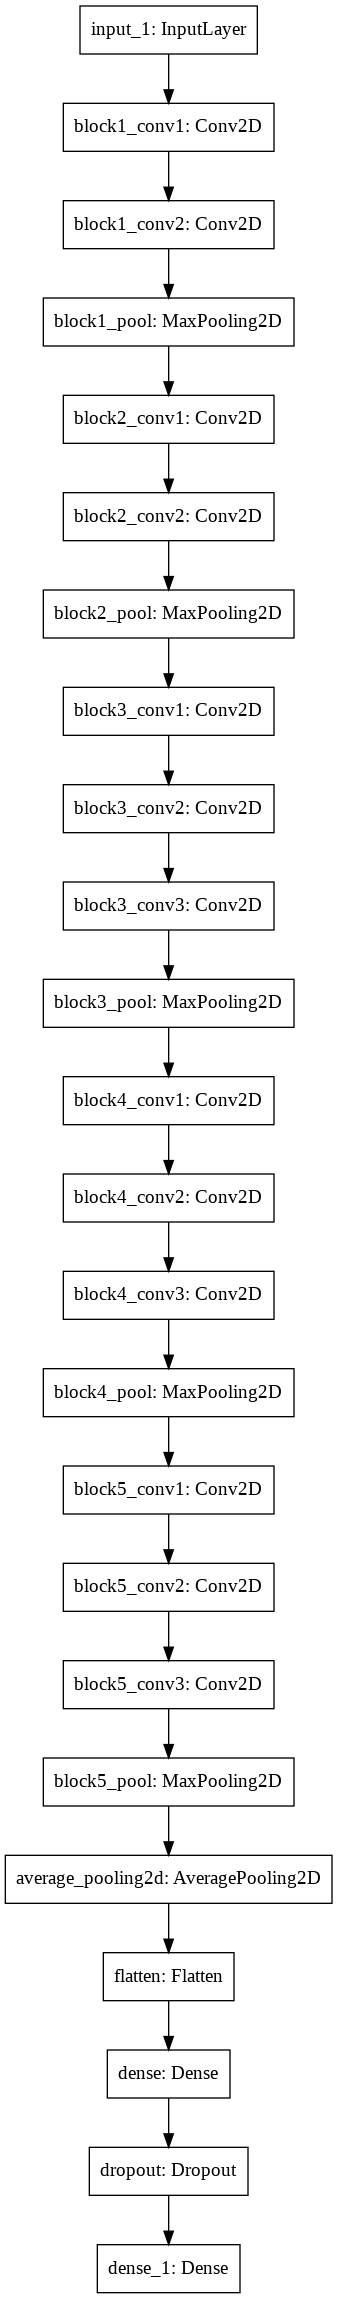

In [7]:
plot_model(model)

In [8]:
model.evaluate(testX,testY, batch_size=BS)

10/10 [==============================] - 0s 6ms/sample - loss: 0.5015 - acc: 0.9000


[0.5014703631401062, 0.9]

In [9]:
# evaluation
print("Eval")

pred = model.predict(testX, batch_size = BS)
pred_idxs = np.argmax(pred,axis = 1)
print(classification_report(testY.argmax(axis=1),pred_idxs,target_names = l.classes_))

Eval
              precision    recall  f1-score   support

       covid       0.83      1.00      0.91         5
      normal       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [0]:
cm = confusion_matrix(testY.argmax(axis=1), pred_idxs)
total = sum(sum(cm))
acc = (cm[0,0]+cm[1,1])/total
rec = cm[0,0]/ (cm[0,0]+cm[0,1])
spec = cm[1,1]/(cm[1,1]+cm[1,0])


In [11]:
print(cm)
print("acc: {:.4f}".format(acc))
print("recall: {:.4f}".format(rec))
print("specificity: {:.4f}".format(spec))

[[5 0]
 [1 4]]
acc: 0.9000
recall: 1.0000
specificity: 0.8000


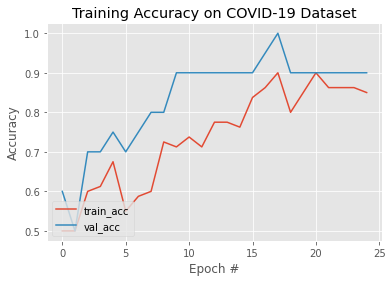

In [12]:
# plots
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("Result/Acc plot.png")


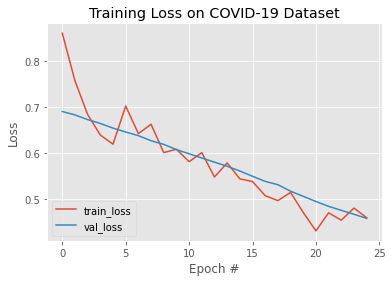

In [13]:
# plots
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("Result/Loss plot.png")


In [0]:
# viz results

pred = model.predict(testX, batch_size = BS)


In [0]:
for i in range(testX.shape[0]):
  img = (255*(testX[i])).astype('uint8')
  # cv2.merge((img[0],img[1],img[2]))
  title = l.classes_[pred_idxs[i]]
  img = add_title(img,title)
  cv2.imwrite("Result/test_img_{}.png".format(i+1),img)
  